# **4. Model Optimization & Selection**

## **4.1 Objective**
* **Goal:** Handle missing data (Imputation) and select the best performing model through Hyperparameter Tuning.
* **Models to Compare:**
1. **Random Forest Regressor:** Robust, handles non-linear data well, hard to overfit.
2. **Gradient Boosting Regressor:** Often achieves higher accuracy by correcting errors iteratively.
* **Strategy:** We will use `Pipeline` to combine Imputation and Modeling, preventing data leakage.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Load Engineered Data
# We load the dataset where we kept ALL rows (including NaNs)
try:
    df = pd.read_csv('../data/UnifiedDataset_Engineered.csv')
    print(f"✅ Data Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: 'UnifiedDataset_Engineered.csv' not found.")

# 2. Define Features & Target
target = '% Death Cardiovascular'
# Drop non-feature columns
features = [col for col in df.columns if col not in [target, 'Country', 'Year']]

print(f"Total Features: {len(features)}")

✅ Data Loaded. Shape: (20760, 33)
Total Features: 30


## **4.2 Preprocessing & Splitting**
**CRITICAL FIX:** Scikit-Learn Pipelines handle missing data in X (features), but NOT in y (target).
We must drop rows where the Target (`% Death Cardiovascular`) is missing before training.

In [5]:
# 1. Drop Rows where Target is NaN
# We preserve rows where Features are NaN (the Imputer will fix those),
# but we cannot train on rows where we don't know the answer.
df_model = df.dropna(subset=[target]).copy()

print(f"Original Rows: {df.shape[0]}")
print(f"Rows with Valid Target: {df_model.shape[0]}")

# 2. Encode Gender (if it is still string)
if df_model['Gender'].dtype == 'object':
    le = LabelEncoder()
    df_model['Gender'] = le.fit_transform(df_model['Gender'])

# 3. Define X and y
X = df_model[features]
y = df_model[target]

# 4. Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data:  {X_test.shape}")

Original Rows: 20760
Rows with Valid Target: 10800
Training Data: (8640, 30)
Testing Data:  (2160, 30)


## **4.3 Model 1: Random Forest (Optimization)**
We use a **Pipeline** that first fills missing values (Imputer), then runs the model.

In [6]:
# Define Pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fills NaNs with column median
    ('rf', RandomForestRegressor(random_state=42))
])

# Define Hyperparameters to Tune
rf_params = {
    'rf__n_estimators': [100, 200],      # Number of trees
    'rf__max_depth': [10, 20, None],     # Depth of trees
    'rf__min_samples_leaf': [1, 4]       # Minimum samples per leaf (prevents overfitting)
}

# Run Grid Search (3-Fold CV)
print("⏳ Training Random Forest (this may take 1-2 mins)...")
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print(f"Best RF Params: {rf_grid.best_params_}")
print(f"Best RF CV Score (R²): {rf_grid.best_score_:.4f}")

⏳ Training Random Forest (this may take 1-2 mins)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 200}
Best RF CV Score (R²): 0.8204


## **4.4 Model 2: Gradient Boosting (Optimization)**
Gradient Boosting usually outperforms Random Forest on tabular data but requires careful tuning.

In [7]:
# Define Pipeline
gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingRegressor(random_state=42))
])

# Define Hyperparameters to Tune
gb_params = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.05, 0.1],    # How fast the model learns
    'gb__max_depth': [3, 5],             # Tree depth (GB usually needs shallower trees)
    'gb__subsample': [0.8, 1.0]          # Train on % of data (0.8 reduces variance)
}

# Run Grid Search
print("⏳ Training Gradient Boosting...")
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)

print(f"Best GB Params: {gb_grid.best_params_}")
print(f"Best GB CV Score (R²): {gb_grid.best_score_:.4f}")

⏳ Training Gradient Boosting...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best GB Params: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 200, 'gb__subsample': 0.8}
Best GB CV Score (R²): 0.8142


## **4.5 Final Comparison & Selection**
We evaluate both optimized models on the **Test Set** (Unseen Data).

------------------------------------------------
FINAL RESULTS
------------------------------------------------
               Model  Test R² Score  Test MAE
0      Random Forest       0.874437  1.924452
1  Gradient Boosting       0.839200  2.333716
------------------------------------------------


/tmp/ipython-input-2988971765.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test R² Score', data=results, palette='viridis')


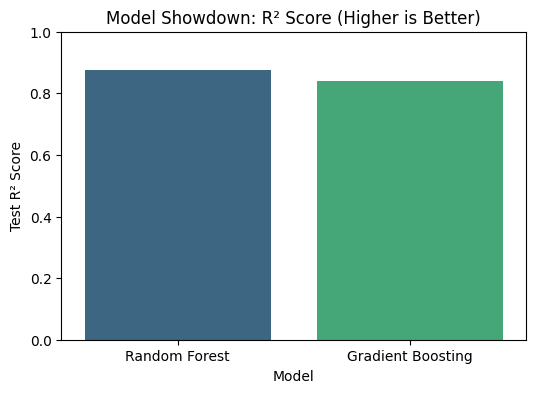

In [8]:
# Get Best Models
rf_best = rf_grid.best_estimator_
gb_best = gb_grid.best_estimator_

# Predict
rf_pred = rf_best.predict(X_test)
gb_pred = gb_best.predict(X_test)

# Calculate Metrics
rf_r2 = r2_score(y_test, rf_pred)
gb_r2 = r2_score(y_test, gb_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

# Create Comparison Table
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'Test R² Score': [rf_r2, gb_r2],
    'Test MAE': [rf_mae, gb_mae]
})

print("------------------------------------------------")
print("FINAL RESULTS")
print("------------------------------------------------")
print(results)
print("------------------------------------------------")

# Visualize R2 Comparison
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Test R² Score', data=results, palette='viridis')
plt.title("Model Showdown: R² Score (Higher is Better)")
plt.ylim(0, 1)
plt.show()

## **4.6 Saving the Winner**
We save the best model to a `.pkl` file so we can use it in our Streamlit App.

In [9]:
if gb_r2 > rf_r2:
    print("🏆 Winner: Gradient Boosting")
    final_model = gb_best
    joblib.dump(final_model, '../models/final_model.pkl')
else:
    print("🏆 Winner: Random Forest")
    final_model = rf_best
    joblib.dump(final_model, '../models/final_model.pkl')

print("✅ Best model saved to '../models/final_model.pkl'")

🏆 Winner: Random Forest
✅ Best model saved to '../models/final_model.pkl'
